In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop, Adadelta, Adam

import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
import os

from utils_nlp import *
from memory_fusion_network import *

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score

np.random.seed(1337) 
tf.random.set_seed(1337)

In [27]:
def load_data(data_name):
    global output_dim

    pickle_data = '../input/cmu-mosi-explore/' + data_name + '.pkl'
    with open(pickle_data, 'rb') as fp:
        data = pickle.load(fp)

    X = [np.concatenate(tuple(data[typ][mod] for typ in ['train', 'valid', 'test']), axis=0) for mod in ['text', 'audio', 'vision']]
    y = np.squeeze(np.concatenate(tuple(data[typ]['labels'] for typ in ['train', 'valid', 'test']), axis=0))

    print(y.shape, y[:10])
    
    if len(y.shape) != 1:
        y = np.argmax(y, axis=1)
        
    mn, mx = np.min(y), np.max(y)
    shift = (mn + mx) / 2

    limit = 1
    roundoff = np.vectorize(lambda t : round_label(t, limit))

    y = roundoff(y - shift)
    
    X, y = remove_labels(X, y, [0])
    y = to_categorical(re_label(y))
    
    return X, y

In [28]:
data_name = 'mmmo_data'
modals = {'T':[0], 'A':[1], 'V':[2],
          'TA':[0,1], 'TV':[0,2], 'AV':[1,2],
          'TAV':[0,1,2]}
data, labels = load_data(data_name)
print([t.shape for t in data])
print(labels.shape)

(340,) [1.5 3.  4.  2.5 3.  4.5 4.5 1.  1.  4. ]
[(311, 21, 300), (311, 21, 74), (311, 21, 35)]
(311, 2)


In [140]:
mode = 'A'
X = [data[i] for i in modals[mode]]
y = labels.astype(np.float64)

X_train, X_test = [], []
y_train, y_test = [], []

# k Fold cross validation
k = 5
kfold_size = y.shape[0] // k

for i in range(k):
    l = i * kfold_size
    r = l + kfold_size
    if i == k - 1 : r = y.shape[0]

    X_train_i, X_test_i = [], []
    for modality in X:
        test = modality[l:r]
        train = np.concatenate((modality[:l], modality[r:]), axis=0)
        X_train_i.append(train)
        X_test_i.append(test)
    y_train_i = np.concatenate((y[:l], y[r:]), axis=0)
    y_test_i = y[l:r]
    
    X_train.append(X_train_i)
    X_test.append(X_test_i)

    y_train.append(y_train_i)
    y_test.append(y_test_i)

In [141]:
K.clear_session()
mem_size = 512
input_shapes = [d.shape[1:] for d in X]
models = [None]*k
for i in range(k):
    models[i] = MFN(input_shapes, output_classes=y.shape[1], mem_size=mem_size)

In [142]:
checkpointer = [None]*k
early_stopping = [None]*k
for i in range(k):
    optimizer = Adam(lr=5e-4)
    model_name = f'current_model_{i+1}.h5'
    early_stopping[i] = EarlyStopping(monitor='val_accuracy', patience=50, mode='max', verbose=1)
    checkpointer[i] = ModelCheckpoint(filepath=model_name, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
    models[i].compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [143]:
history = [None]*k
for i in range(k):
    history[i] = models[i].fit(X_train[i], y_train[i],
                              batch_size = 128 * 4,
                              epochs = 200,
                              shuffle = True,
                              validation_split = 0.15,
                              callbacks = [checkpointer[i], early_stopping[i]])

Epoch 1/200
1/1 [==============================] - ETA: 0s - loss: 1.0932 - accuracy: 0.5782
Epoch 00001: val_accuracy improved from -inf to 0.71053, saving model to current_model_1.h5
1/1 [==============================] - 1s 643ms/step - loss: 1.0932 - accuracy: 0.5782 - val_loss: 1.0051 - val_accuracy: 0.7105
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 1.0623 - accuracy: 0.6540
Epoch 00002: val_accuracy did not improve from 0.71053
1/1 [==============================] - 0s 33ms/step - loss: 1.0623 - accuracy: 0.6540 - val_loss: 0.9461 - val_accuracy: 0.7105
Epoch 3/200
1/1 [==============================] - ETA: 0s - loss: 1.0643 - accuracy: 0.6777
Epoch 00003: val_accuracy did not improve from 0.71053
1/1 [==============================] - 0s 32ms/step - loss: 1.0643 - accuracy: 0.6777 - val_loss: 0.9046 - val_accuracy: 0.7105
Epoch 4/200
1/1 [==============================] - ETA: 0s - loss: 1.0207 - accuracy: 0.7204
Epoch 00004: val_accuracy improved from 0

Epoch 30/200
1/1 [==============================] - ETA: 0s - loss: 0.8844 - accuracy: 0.7536
Epoch 00030: val_accuracy did not improve from 0.86842
1/1 [==============================] - 0s 31ms/step - loss: 0.8844 - accuracy: 0.7536 - val_loss: 0.7900 - val_accuracy: 0.8684
Epoch 31/200
1/1 [==============================] - ETA: 0s - loss: 0.8824 - accuracy: 0.7630
Epoch 00031: val_accuracy did not improve from 0.86842
1/1 [==============================] - 0s 34ms/step - loss: 0.8824 - accuracy: 0.7630 - val_loss: 0.7860 - val_accuracy: 0.8684
Epoch 32/200
1/1 [==============================] - ETA: 0s - loss: 0.8769 - accuracy: 0.7630
Epoch 00032: val_accuracy did not improve from 0.86842
1/1 [==============================] - 0s 32ms/step - loss: 0.8769 - accuracy: 0.7630 - val_loss: 0.7812 - val_accuracy: 0.8684
Epoch 33/200
1/1 [==============================] - ETA: 0s - loss: 0.8808 - accuracy: 0.7583
Epoch 00033: val_accuracy did not improve from 0.86842
1/1 [===============

Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 1.1217 - accuracy: 0.5450
Epoch 00002: val_accuracy did not improve from 0.71053
1/1 [==============================] - 0s 32ms/step - loss: 1.1217 - accuracy: 0.5450 - val_loss: 1.0393 - val_accuracy: 0.7105
Epoch 3/200
1/1 [==============================] - ETA: 0s - loss: 1.0920 - accuracy: 0.5450
Epoch 00003: val_accuracy improved from 0.71053 to 0.76316, saving model to current_model_2.h5
1/1 [==============================] - 0s 115ms/step - loss: 1.0920 - accuracy: 0.5450 - val_loss: 1.0071 - val_accuracy: 0.7632
Epoch 4/200
1/1 [==============================] - ETA: 0s - loss: 1.0988 - accuracy: 0.5877
Epoch 00004: val_accuracy did not improve from 0.76316
1/1 [==============================] - 0s 32ms/step - loss: 1.0988 - accuracy: 0.5877 - val_loss: 0.9580 - val_accuracy: 0.7632
Epoch 5/200
1/1 [==============================] - ETA: 0s - loss: 1.0548 - accuracy: 0.6303
Epoch 00005: val_accuracy improved fro

Epoch 31/200
1/1 [==============================] - ETA: 0s - loss: 0.9053 - accuracy: 0.7393
Epoch 00031: val_accuracy did not improve from 0.86842
1/1 [==============================] - 0s 31ms/step - loss: 0.9053 - accuracy: 0.7393 - val_loss: 0.7826 - val_accuracy: 0.8684
Epoch 32/200
1/1 [==============================] - ETA: 0s - loss: 0.8825 - accuracy: 0.7251
Epoch 00032: val_accuracy did not improve from 0.86842
1/1 [==============================] - 0s 30ms/step - loss: 0.8825 - accuracy: 0.7251 - val_loss: 0.7772 - val_accuracy: 0.8684
Epoch 33/200
1/1 [==============================] - ETA: 0s - loss: 0.8898 - accuracy: 0.7346
Epoch 00033: val_accuracy did not improve from 0.86842
1/1 [==============================] - 0s 29ms/step - loss: 0.8898 - accuracy: 0.7346 - val_loss: 0.7721 - val_accuracy: 0.8684
Epoch 34/200
1/1 [==============================] - ETA: 0s - loss: 0.8886 - accuracy: 0.7299
Epoch 00034: val_accuracy did not improve from 0.86842
1/1 [===============

Epoch 61/200
1/1 [==============================] - ETA: 0s - loss: 0.7832 - accuracy: 0.7346
Epoch 00061: val_accuracy did not improve from 0.86842
1/1 [==============================] - 0s 47ms/step - loss: 0.7832 - accuracy: 0.7346 - val_loss: 0.6891 - val_accuracy: 0.8684
Epoch 62/200
1/1 [==============================] - ETA: 0s - loss: 0.7967 - accuracy: 0.7536
Epoch 00062: val_accuracy did not improve from 0.86842
1/1 [==============================] - 0s 52ms/step - loss: 0.7967 - accuracy: 0.7536 - val_loss: 0.6852 - val_accuracy: 0.8684
Epoch 63/200
1/1 [==============================] - ETA: 0s - loss: 0.7876 - accuracy: 0.7299
Epoch 00063: val_accuracy did not improve from 0.86842
1/1 [==============================] - 0s 31ms/step - loss: 0.7876 - accuracy: 0.7299 - val_loss: 0.6816 - val_accuracy: 0.8684
Epoch 64/200
1/1 [==============================] - ETA: 0s - loss: 0.7958 - accuracy: 0.7251
Epoch 00064: val_accuracy did not improve from 0.86842
1/1 [===============

1/1 [==============================] - ETA: 0s - loss: 0.9086 - accuracy: 0.7630
Epoch 00026: val_accuracy did not improve from 0.86842
1/1 [==============================] - 0s 29ms/step - loss: 0.9086 - accuracy: 0.7630 - val_loss: 0.8140 - val_accuracy: 0.8421
Epoch 27/200
1/1 [==============================] - ETA: 0s - loss: 0.8974 - accuracy: 0.7536
Epoch 00027: val_accuracy did not improve from 0.86842
1/1 [==============================] - 0s 29ms/step - loss: 0.8974 - accuracy: 0.7536 - val_loss: 0.8057 - val_accuracy: 0.8684
Epoch 28/200
1/1 [==============================] - ETA: 0s - loss: 0.8911 - accuracy: 0.7725
Epoch 00028: val_accuracy did not improve from 0.86842
1/1 [==============================] - 0s 32ms/step - loss: 0.8911 - accuracy: 0.7725 - val_loss: 0.7979 - val_accuracy: 0.8684
Epoch 29/200
1/1 [==============================] - ETA: 0s - loss: 0.8863 - accuracy: 0.7678
Epoch 00029: val_accuracy did not improve from 0.86842
1/1 [============================

Epoch 56/200
1/1 [==============================] - ETA: 0s - loss: 0.7376 - accuracy: 0.7915
Epoch 00056: val_accuracy did not improve from 0.86842
1/1 [==============================] - 0s 33ms/step - loss: 0.7376 - accuracy: 0.7915 - val_loss: 0.6463 - val_accuracy: 0.8684
Epoch 57/200
1/1 [==============================] - ETA: 0s - loss: 0.7570 - accuracy: 0.7725
Epoch 00057: val_accuracy did not improve from 0.86842
1/1 [==============================] - 0s 34ms/step - loss: 0.7570 - accuracy: 0.7725 - val_loss: 0.6330 - val_accuracy: 0.8684
Epoch 58/200
1/1 [==============================] - ETA: 0s - loss: 0.7574 - accuracy: 0.8009
Epoch 00058: val_accuracy did not improve from 0.86842
1/1 [==============================] - 0s 33ms/step - loss: 0.7574 - accuracy: 0.8009 - val_loss: 0.6288 - val_accuracy: 0.8684
Epoch 59/200
1/1 [==============================] - ETA: 0s - loss: 0.7452 - accuracy: 0.7867
Epoch 00059: val_accuracy did not improve from 0.86842
1/1 [===============

Epoch 26/200
1/1 [==============================] - ETA: 0s - loss: 0.9339 - accuracy: 0.7346
Epoch 00026: val_accuracy did not improve from 0.84211
1/1 [==============================] - 0s 31ms/step - loss: 0.9339 - accuracy: 0.7346 - val_loss: 0.8649 - val_accuracy: 0.8158
Epoch 27/200
1/1 [==============================] - ETA: 0s - loss: 0.8941 - accuracy: 0.7441
Epoch 00027: val_accuracy did not improve from 0.84211
1/1 [==============================] - 0s 29ms/step - loss: 0.8941 - accuracy: 0.7441 - val_loss: 0.8579 - val_accuracy: 0.8158
Epoch 28/200
1/1 [==============================] - ETA: 0s - loss: 0.8961 - accuracy: 0.7156
Epoch 00028: val_accuracy did not improve from 0.84211
1/1 [==============================] - 0s 53ms/step - loss: 0.8961 - accuracy: 0.7156 - val_loss: 0.8507 - val_accuracy: 0.8158
Epoch 29/200
1/1 [==============================] - ETA: 0s - loss: 0.8861 - accuracy: 0.7346
Epoch 00029: val_accuracy did not improve from 0.84211
1/1 [===============

Epoch 00055: early stopping
Epoch 1/200
1/1 [==============================] - ETA: 0s - loss: 1.1225 - accuracy: 0.5524
Epoch 00001: val_accuracy improved from -inf to 0.73684, saving model to current_model_5.h5
1/1 [==============================] - 1s 603ms/step - loss: 1.1225 - accuracy: 0.5524 - val_loss: 0.9800 - val_accuracy: 0.7368
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 1.0777 - accuracy: 0.6619
Epoch 00002: val_accuracy did not improve from 0.73684
1/1 [==============================] - 0s 29ms/step - loss: 1.0777 - accuracy: 0.6619 - val_loss: 0.9656 - val_accuracy: 0.7105
Epoch 3/200
1/1 [==============================] - ETA: 0s - loss: 1.0737 - accuracy: 0.7000
Epoch 00003: val_accuracy did not improve from 0.73684
1/1 [==============================] - 0s 28ms/step - loss: 1.0737 - accuracy: 0.7000 - val_loss: 0.9768 - val_accuracy: 0.7105
Epoch 4/200
1/1 [==============================] - ETA: 0s - loss: 1.0300 - accuracy: 0.7333
Epoch 00004: 

Epoch 31/200
1/1 [==============================] - ETA: 0s - loss: 0.8868 - accuracy: 0.7571
Epoch 00031: val_accuracy did not improve from 0.73684
1/1 [==============================] - 0s 29ms/step - loss: 0.8868 - accuracy: 0.7571 - val_loss: 0.9494 - val_accuracy: 0.6842
Epoch 32/200
1/1 [==============================] - ETA: 0s - loss: 0.8728 - accuracy: 0.7571
Epoch 00032: val_accuracy did not improve from 0.73684
1/1 [==============================] - 0s 30ms/step - loss: 0.8728 - accuracy: 0.7571 - val_loss: 0.9450 - val_accuracy: 0.6842
Epoch 33/200
1/1 [==============================] - ETA: 0s - loss: 0.8956 - accuracy: 0.7524
Epoch 00033: val_accuracy did not improve from 0.73684
1/1 [==============================] - 0s 30ms/step - loss: 0.8956 - accuracy: 0.7524 - val_loss: 0.9418 - val_accuracy: 0.6842
Epoch 34/200
1/1 [==============================] - ETA: 0s - loss: 0.8485 - accuracy: 0.7619
Epoch 00034: val_accuracy did not improve from 0.73684
1/1 [===============

In [148]:
classes = sorted(list(set(sorted(list(np.argmax(y, axis=1))))))
filename = '_'.join([data_name.replace('_data', ''), mode, str(len(classes))+'way', f'memsz{mem_size}', f'{k}fold'])
print(filename)
y_preds, y_trues = [], []
acc = 0.0
prfs_m = np.zeros((3,), dtype=np.float64)
prfs_w = np.zeros((3,), dtype=np.float64)
cm = None
for i in range(k):
    preds = models[i].predict(X_test[i])
    y_preds.append(np.argmax(preds, axis=1))
    y_trues.append(np.argmax(y_test[i], axis=1))
    
    cm_i = confusion_matrix(y_trues[i], y_preds[i])
    cm_i = cm_i.astype('float') / np.sum(cm_i, axis=1, keepdims=True)
    if cm is None : cm = cm_i
    else : cm += cm_i
    
    acc += accuracy_score(y_trues[i], y_preds[i])
    prfs_m += np.array(precision_recall_fscore_support(y_trues[i], y_preds[i], zero_division=0, average='macro')[:-1])
    prfs_w += np.array(precision_recall_fscore_support(y_trues[i], y_preds[i], zero_division=0, average='weighted')[:-1])
    
print("Confusion Matrix :\n", cm / k)
print("Accuracy ", acc / k)
print("Macro Classification Report :", prfs_m / k)
print("Weighted Classification Report :", prfs_w / k)
print('-' * 60)

mmmo_A_2way_memsz512_5fold
Confusion Matrix :
 [[0.45189394 0.54810606]
 [0.09382852 0.90617148]]
Accuracy  0.7426523297491039
Macro Classification Report : [0.74455235 0.67903271 0.68539035]
Weighted Classification Report : [0.75437374 0.74265233 0.72626271]
------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

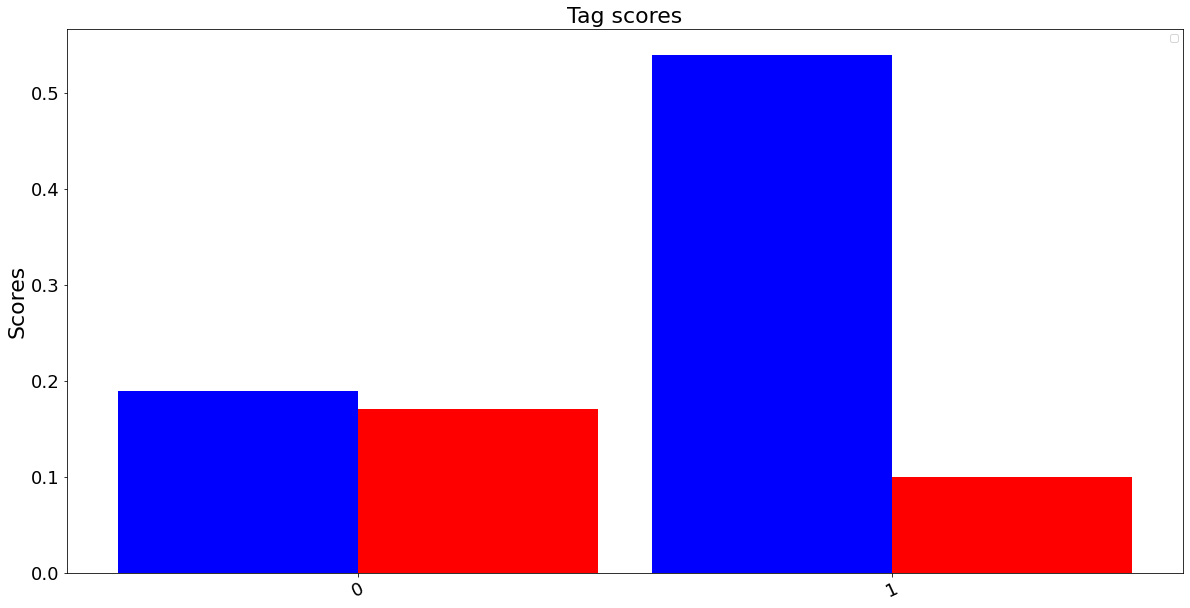

<Figure size 432x288 with 0 Axes>

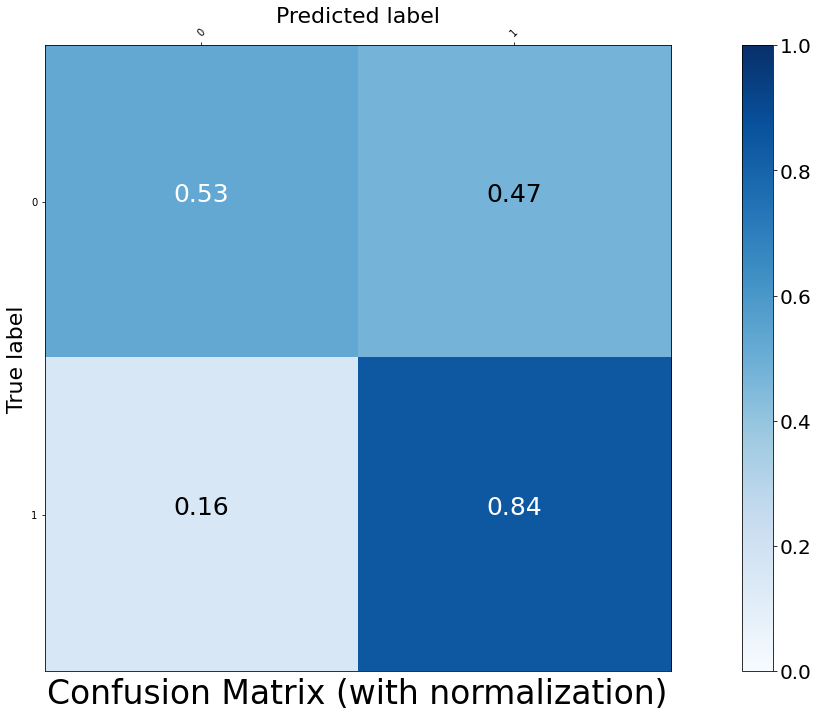

In [145]:
# average your cm, report, score and support variables over k runs
class_names = None
report = None
support = None
cm, scores = None, None

for y_true, y_pred in zip(y_trues, y_preds):
    class_names, report_, support_ = get_report(y_true, y_pred, classes)
    cm_ = confusion_matrix(y_true, y_pred, labels=classes)
    scores_ = get_scores(y_true, y_pred, classes)
    
    if report is None : report = np.zeros_like(report_, dtype=np.float64)
    report += report_
    
    if support is None : support = np.zeros_like(support_, dtype=np.float64)
    support += support_
    
    if cm is None : cm = np.zeros_like(cm_, dtype=np.float64)
    cm += cm_
    
    if scores is None : scores = np.zeros_like(scores_, dtype=np.float64)
    scores += scores_

report /= k
support /= k
cm /= k
scores /= k

plot_tag_scores(classes, scores, filename=filename+'_tag_scores')
plot_confusion_matrix(classes, cm, filename=filename+'_cm')

<Figure size 432x288 with 0 Axes>

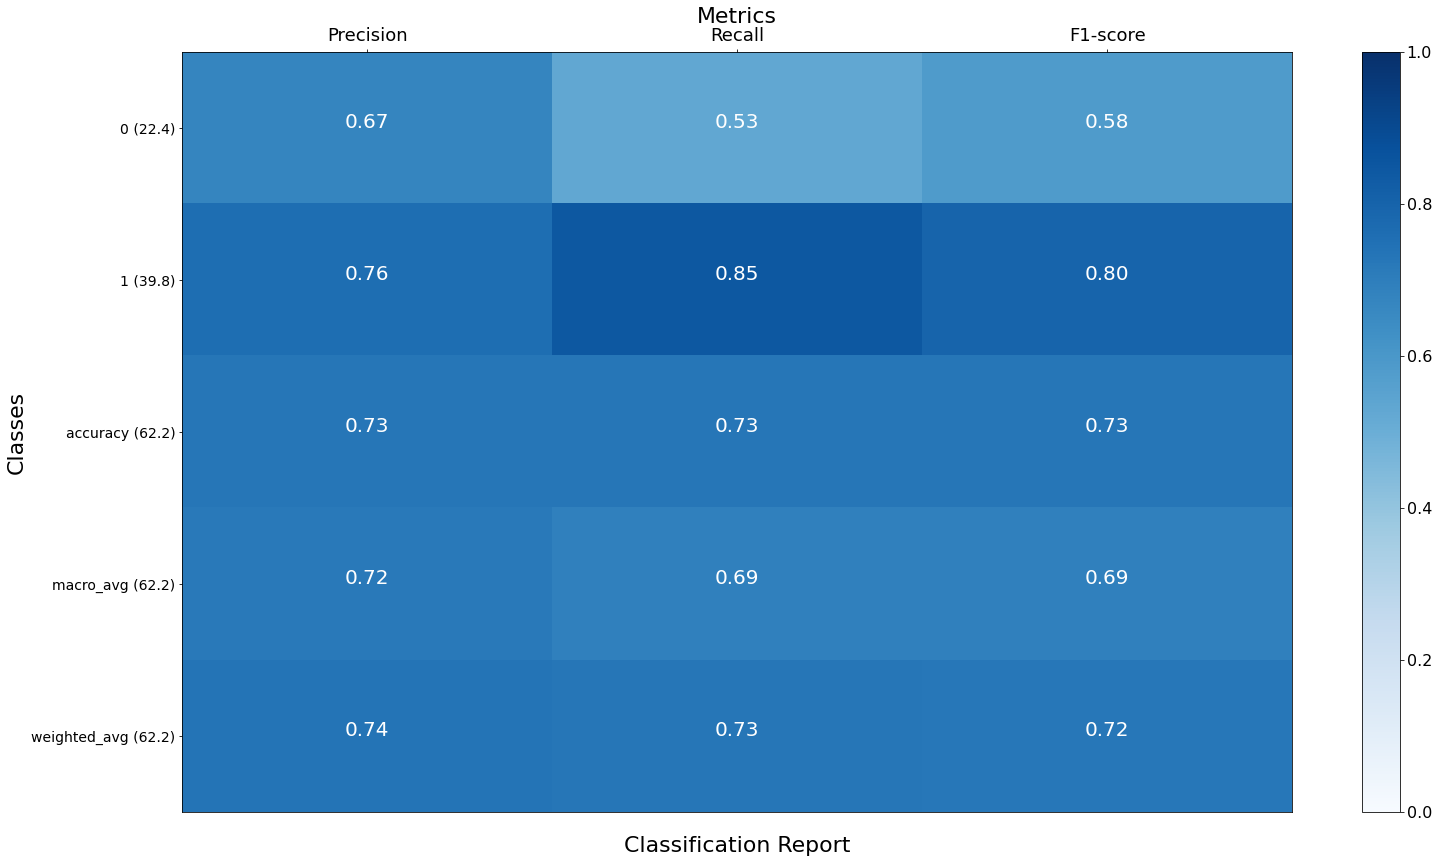

In [146]:
plot_clf_report(class_names, report, support, filename=filename+'_clf_report')

In [147]:
for i in range(k):
    model_name = f'current_model_{i+1}.h5'
    if os.path.isfile(model_name):
        models[i].load_weights(model_name)
        print(f'Loaded saved Model Fold {i+1}!')

Loaded saved Model Fold 1!
Loaded saved Model Fold 2!
Loaded saved Model Fold 3!
Loaded saved Model Fold 4!
Loaded saved Model Fold 5!


In [149]:
!zip -r results.zip *.png

updating: mmmo_AV_2way_memsz512_5fold_clf_report.png (deflated 15%)
updating: mmmo_AV_2way_memsz512_5fold_cm.png (deflated 11%)
updating: mmmo_AV_2way_memsz512_5fold_tag_scores.png (deflated 29%)
updating: mmmo_A_2way_memsz512_5fold_clf_report.png (deflated 15%)
updating: mmmo_A_2way_memsz512_5fold_cm.png (deflated 11%)
updating: mmmo_A_2way_memsz512_5fold_tag_scores.png (deflated 29%)
updating: mmmo_TAV_2way_memsz512_5fold_clf_report.png (deflated 14%)
updating: mmmo_TAV_2way_memsz512_5fold_cm.png (deflated 12%)
updating: mmmo_TAV_2way_memsz512_5fold_tag_scores.png (deflated 27%)
updating: mmmo_TAV_4way_memsz512_5fold_clf_report.png (deflated 14%)
updating: mmmo_TAV_4way_memsz512_5fold_cm.png (deflated 12%)
updating: mmmo_TAV_4way_memsz512_5fold_tag_scores.png (deflated 23%)
updating: mmmo_TA_2way_memsz512_5fold_clf_report.png (deflated 15%)
updating: mmmo_TA_2way_memsz512_5fold_cm.png (deflated 11%)
updating: mmmo_TA_2way_memsz512_5fold_tag_scores.png (deflated 29%)
updating: mmmo_TV

In [ ]:
!rm -rf *.png